<a href="https://colab.research.google.com/github/yeyevtushenko/AI/blob/Lesson27.03.2024/Lesson27_03_2024_AI_H_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Імпорт модулів

In [16]:
import pandas as pd
import numpy as np

Дані медичне страхування

In [2]:
# трохи обробки даних
df = pd.read_csv('https://raw.githubusercontent.com/HalyshAnton/IT-Step-Pyton-AI/main/module3/data/insurance.csv')

df['sex'] = df['sex'].map({'male': 0, 'female':1})
df['smoker'] = df['smoker'].map({'no': 0, 'yes':1})

df = df.drop(columns=['region'])

data = df[['age', 'bmi', 'expenses']]
df[['age', 'bmi', 'expenses']] = (data - data.min()) / (data.max() - data.min())

In [3]:
df.head()

,age,sex,bmi,children,smoker,expenses
0,0.021739,1,0.320755,0,1,0.251611
1,0.000000,0,0.479784,1,0,0.009636
2,0.217391,0,0.458221,3,0,0.053115
3,0.326087,0,0.180593,0,0,0.333010
4,0.304348,0,0.347709,0,0,0.043816


Потрібно на основі інформації людини спрогнозувати розмір її страховки `expenses`

# Завдання 1
Створіть клас Dataset

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)

In [7]:
class DataSet(Dataset):
  def __init__(self, X, y) -> None:
    self.X = torch.FloatTensor(X.values).to(device)
    self.y = torch.FloatTensor(y.values).to(device)
    self.y = self.y.reshape(-1, 1)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

X = df.drop(columns='expenses')
y = df['expenses']
dataset = DataSet(X, y)

# Завдання 2
Створіть DataLoader. Перевірте розміри даних в першому пакеті. Розмір пакетів оберіть самостійно

In [8]:
batch_size = 64
dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True,
                        generator=torch.Generator(device=device))

In [9]:
X_batch, y_batch = next(iter(dataloader))

In [10]:
X_batch.size()

torch.Size([64, 5])

In [11]:
y_batch.size()

torch.Size([64, 1])

# Завдання 3
Створіть нейромережу:
* Кількість шарів оберіть між 1-5
* Виберіть різні функції активації: Relu, LeakyRelu, Swish
* Кілкість нейронів у прихованих шарах повинна **не зростати**

In [12]:
from torch import nn

In [13]:
model = nn.Sequential(
    nn.Linear(5, 10),
    nn.ReLU(),
    nn.Linear(10, 8),
    nn.ReLU(),
    nn.Linear(8, 5),
    nn.ReLU(),
    nn.Linear(5, 1)
)

model

Sequential(
  (0): Linear(in_features=5, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=8, bias=True)
  (3): ReLU()
  (4): Linear(in_features=8, out_features=5, bias=True)
  (5): ReLU()
  (6): Linear(in_features=5, out_features=1, bias=True)
)

In [14]:
from torchsummary import summary

summary(model, input_size=(5,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]              60
              ReLU-2                   [-1, 10]               0
            Linear-3                    [-1, 8]              88
              ReLU-4                    [-1, 8]               0
            Linear-5                    [-1, 5]              45
              ReLU-6                    [-1, 5]               0
            Linear-7                    [-1, 1]               6
Total params: 199
Trainable params: 199
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


# Завдання 4
Визначте функцію втрат та оптимізатор

In [15]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Завдання 5
Натренуйте нейромережу. візміть невелику кількість епох

In [17]:
num_epochs = 30
losses = []
for epoch in range(num_epochs):
  losses_ = []
  for X_batch, y_batch in dataloader:
    prediction = model(X_batch)
    loss = loss_fn(prediction, y_batch)

    losses_.append(loss.item())

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

  losses.append(np.mean(losses_))

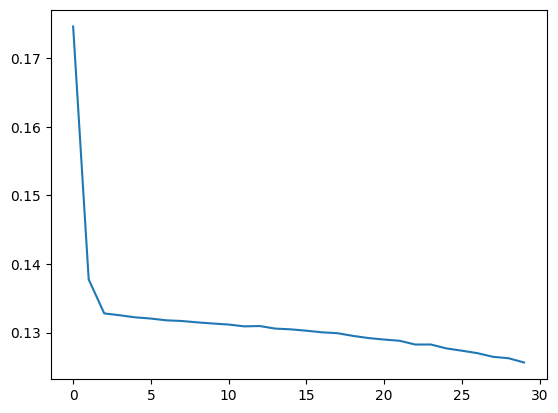

In [18]:
import matplotlib.pyplot as plt

plt.plot(losses)

# Завдання 6
Збережіть нейромережу та зробіть прогноз

In [19]:
torch.save(model, 'model.pt')

In [20]:
loaded_model = torch.load('model.pt')

In [21]:
loaded_model

Sequential(
  (0): Linear(in_features=5, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=8, bias=True)
  (3): ReLU()
  (4): Linear(in_features=8, out_features=5, bias=True)
  (5): ReLU()
  (6): Linear(in_features=5, out_features=1, bias=True)
)

In [22]:
X_data = torch.FloatTensor([X.iloc[0,:].values]).to(device)


print(X_data)
print(X_data.shape)

tensor([[0.0217, 1.0000, 0.3208, 0.0000, 1.0000]])
torch.Size([1, 5])


<ipython-input-22-f5113c9a51f4>:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  X_data = torch.FloatTensor([X.iloc[0,:].values]).to(device)


In [23]:
with torch.no_grad():
  print(loaded_model(X_data))

tensor([[0.1487]])
